# Cálculo de la Anomalia de Bouger

<img src='estGrav.png' width="1000" height="1000">

## Altura ortométrica: 203.552m
## $\rho=2670\frac{kg}{m^3}$
## $G$ es la constante de gravitación de Newton

<img src='Apuntes.png' width="1000" height="1000">

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from osgeo import gdal
from osgeo import osr

import geopandas as gpd

import rasterio
from rasterio.mask import mask
import geopandas as gpd

import matplotlib.ticker as mticker
from matplotlib import cm

import os

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
#from cartopy.util import add_cyclic_point
import earthpy.spatial as es

import cv2 as cv
from mpl_toolkits.axes_grid1 import make_axes_locatable

from glob import glob
import swifter

import io
import requests

from selenium import webdriver
from selenium.webdriver.support.ui import Select

import time

from scipy import constants
from geopy.distance import geodesic

/Users/Raul/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Cálculo de la Gravedad

In [4]:
def gN(phi):
    #g=978.049*(1+(0.0052884*(np.sin(np.radians(phi))**2))-0.0000059*(np.sin(2*np.radians(phi))**2)) #Internacional 
    #g=978.0327*(1+(0.0053024*(np.sin(np.radians(phi))**2))-0.0000058*(np.sin(2*np.radians(phi))**2)) #Cassini
    g=978.031846*(1+(0.0053024*(np.sin(np.radians(phi))**2))-0.0000058*(np.sin(2*np.radians(phi))**2))*1000 #Moritz
    return g

## Cálculo de el efecto Atmosférico

In [5]:
def catm(h):
    cat=0.874-((9.9e-5)*hgeo)+((3.56e-9)*hgeo**2)
    return cat

## Cálculo de la Anomalia de Bouger Simple

In [6]:
def AB(g,phi,hgeo):
    dgb=g+.1966389609*hgeo-gN(phi)*1000
    return dgb

## <center>$\Delta g_{B}=g_{B}-\gamma$</center>

Donde:
* $\gamma$ es la gravedad noemal dada por la ecuación de Cassini
* $g_{B}=g_{obs}+0.19663896097H$ ; siendo la $H$ la altura ortométrica en metros

In [5]:
# Ejemplo de CU

hgeo=2276.565
lat=19.33061111
g=977925.1286


AB(g,lat,hgeo) #+4.27 #cT #Cassini

-225.9346450783778

## Función para calcular la Anomalía de Bouger simple y completa

Se necistan cargar el csv correspondiente a los Bancos de Nivel Verticales y las estaciones Gravimétricas del municipio de interes

[Ir al sitio](https://www.inegi.org.mx/app/geo2/rgnp/)

In [70]:
mun=gpd.read_file('/Users/Raul/Desktop/Programacion/Python/Covid/muni_2018gw/muni_2018gw.shp')
mun=mun.to_crs({'init': 'epsg:6365'})

mex=gpd.read_file('/Users/Raul/Desktop/Programacion/Python/Covid/dest2018gw/dest2018gw.shp')
mex=mex.to_crs({'init': 'epsg:6365'})

In [71]:
mu=mun['CVEGEO']

In [6]:
def est(ent):

    si=[]
    df=pd.DataFrame()

    for i in mu:

        try:
            #s=requests.get('https://www.inegi.org.mx/app/geo2/rgnp/descargaArchivoGestor.do?ruta=/data/geo/marcasgeo/CSV_'+i+'_EGG.csv')
            #egg=pd.read_csv(io.StringIO(s.text),names=['ID','Grav','Bs','Bc','Ct','lat','lon'],skiprows=1,usecols=[0,8,17,18,19,20,21])
            egg=pd.read_csv('https://www.inegi.org.mx/app/geo2/rgnp/descargaArchivoGestor.do?ruta=/data/geo/marcasgeo/CSV_'+i+'_EGG.csv'
                            ,names=['ID','Grav','Bs','Bc','Ct','lat','lon'],skiprows=1,usecols=[0,8,17,18,19,20,21])
              
            si.extend(list(np.repeat(i,len(egg))))
            df=df.append(egg,ignore_index=True)

            
        except:
            pass
    
    df['CVE']=si
    
    return df

In [153]:
def est2(ent):

    si=[]
    df=pd.DataFrame()

    for i in mu.unique():

        try:
            #s=requests.get('https://www.inegi.org.mx/app/geo2/rgnp/descargaArchivoGestor.do?ruta=/data/geo/marcasgeo/CSV_'+i+'_EGG.csv')
            #egg=pd.read_csv(io.StringIO(s.text),names=['ID','Grav','Bs','Bc','Ct','lat','lon'],skiprows=1,usecols=[0,8,17,18,19,20,21])
    
            egg=pd.read_csv('https://www.inegi.org.mx/app/geo2/rgnp/descargaArchivoGestor.do?ruta=/data/geo/marcasgeo/CSV_'+i+'_EGV(BN).csv',
               names=['ID','hNAVD29','hNAVD88','lat','lon'],usecols=[0,8,9,18,19],skiprows=1)
              
            si.extend(list(np.repeat(i,len(egg))))
            df=df.append(egg,ignore_index=True)

            
        except:
            pass
    
    df['CVE']=si
    
    return df

## WebScrapping

In [99]:
def query(rut):
    
        ent=rut.split('=')[-2].split('&')[0]
        time.sleep(7)
        driver = webdriver.Safari()
        driver.get(rut)
        time.sleep(10)
        content = driver.find_element_by_xpath("/html/body/div[4]/div[2]/div/div/div[8]/div[1]/select")
        select = Select(content)
        all_options = content.find_elements_by_tag_name("option")

        i=0
        for option in all_options:
            
            try:

                if i==0:
                    #print("Ent: "+ent+" Municipio: %s" % option.get_attribute("value"))
                    time.sleep(10)
                    select.select_by_value(option.get_attribute("value"))
                    #print('Opcion Clickeado!')
                    time.sleep(10)
                else:
                    opt=all_opt[i]
                    #print("Ent: "+ent+" Municipio: %s" % opt.get_attribute("value"))
                    time.sleep(10)
                    select.select_by_value(opt.get_attribute("value"))
                    #print('Opcion Clickeado!')
                    time.sleep(10)


                csv=driver.find_element_by_xpath('/html/body/div[4]/div[2]/div/div/div[8]/div[2]/div/ul/li[4]/a')
                driver.execute_script("arguments[0].click();", csv)
                #print('Consulta realizada!')
                time.sleep(10)

                driver.get(rut)
                time.sleep(10)
                content = driver.find_element_by_xpath("/html/body/div[4]/div[2]/div/div/div[8]/div[1]/select")
                select = Select(content)
                all_opt = content.find_elements_by_tag_name("option")
                i+=1

            except:
                time.sleep(10)
                driver.get(rut)
                time.sleep(10)
                content = driver.find_element_by_xpath("/html/body/div[4]/div[2]/div/div/div[8]/div[1]/select")
                select = Select(content)
                all_opt = content.find_elements_by_tag_name("option")

                opt=all_opt[i]
                #print("Ent: "+ent+" Municipio: %s" % opt.get_attribute("value"))
                time.sleep(10)
                select.select_by_value(opt.get_attribute("value"))
                #print('Opcion Clickeado!')
                time.sleep(10)


                csv=driver.find_element_by_xpath('/html/body/div[4]/div[2]/div/div/div[8]/div[2]/div/ul/li[4]/a')
                driver.execute_script("arguments[0].click();", csv)
                #print('Consulta realizada!')
                time.sleep(10)
                
                driver.get(rut)
                time.sleep(10)
                content = driver.find_element_by_xpath("/html/body/div[4]/div[2]/div/div/div[8]/div[1]/select")
                select = Select(content)
                all_opt = content.find_elements_by_tag_name("option")

                i+=1
        
        time.sleep(5)
        driver.close()

In [154]:
evs=est2('19')

In [133]:
egg=est('19')

In [136]:
#    for i in mun['CVE_ENT'].unique():
#        print(i)
#        rut="https://www.inegi.org.mx/app/geo2/rgnp/MarcasXEstado.jsp?cveEdo="+i+"&tipo=2"
#        try:
#            query(rut)
#
#        except:
#              query(rut)
#
#
#    print('ultimo jalon')
#    evs=est2('19')
#    #evs.to_csv('allEV.csv',index=False)  

In [143]:
egg.to_csv('allEGG2.csv',index=False)

In [156]:
evs.to_csv('allEV2.csv',index=False)  

In [182]:
res=pd.merge(egg,evs,on=['ID','CVE','lon','lat'])

In [167]:
egg=pd.read_csv('allEGG2.csv')

In [163]:
res.to_csv('allDATA.csv',index=False)  

In [6]:
egg=pd.read_csv('/Users/Raul/Desktop/Sexto/Geodesia 3/EGG/Monterrey/CSV_19039_EGG.csv', encoding='ISO-8859-1') # Estaciones gravimetricas
ev=pd.read_csv('/Users/Raul/Desktop/Sexto/Geodesia 3/EGG/Monterrey/CSV_19039_EGV(BN).csv', encoding='ISO-8859-1') # BNV

In [7]:
def ABmun(egg,ev): 
    sv=pd.merge(egg,ev,on='Denominación')

    c1=[]
    c2=[]
    c3=[]
    c4=[]
    c5=[]
    c6=[]
    
    for d,i,j,g,a,c,ac in zip(sv['Denominación'],sv['Latitud decimal_y'],sv['Altura Ortométrica NAVD29'],
                              sv['Gravedad'],sv['Anomalía de Bouguer simple'],sv['Corrección Topográfica'],
                              sv['Anomalía de Bouguer completa']):

        A=AB(float(g[:-5]),i,j)
        c1.append(d)
        c2.append(A)
        c3.append(a)
        c4.append(A+float(c[:-5]))
        c5.append(ac)
        c6.append((2670*j)/(j+100*1000))
        
        #print(d,A,a,A+float(c[:-5]),ac)
    res=pd.DataFrame({'id':c1,'Bouger Cal.':c2,'Bouger Teo':c3,'Bouger Completo Cal.':c4, 
                      'Bouger Completo Teo.':c5,'$\Delta\rho$':c6})
    
    return res

In [8]:
ABmun(egg,ev)

id  Bouger Cal.      Bouger Teo  Bouger Completo Cal.  \
0      J_80  -103.570925  -103.2850 mGal           -101.560925   
1   BNT_576  -105.746098  -104.2672 mGal           -103.756098   
2   BNT_585  -107.621498  -106.5100 mGal           -102.931498   
3    V19520  -104.279001  -104.0490 mGal           -102.509001   
4    V19489  -103.517337  -103.2870 mGal           -101.927337   
5    V19488  -102.600659  -102.3710 mGal           -101.200659   
6    V19551  -109.273776  -109.0780 mGal           -103.683776   
7    V19550  -109.562406   -78.7430 mGal           -103.272406   
8    V19553  -108.717916  -108.4670 mGal           -103.707916   
9    V19549  -109.208639  -108.9190 mGal           -103.668639   
10   V19441  -109.231869  -108.8110 mGal           -103.671869   
11   V19528  -107.741867  -107.4370 mGal           -103.461867   
12   V19527  -106.766407  -106.2780 mGal           -103.256407   
13   V19525  -105.384232  -104.9930 mGal           -102.834232   
14   V19524  -104.804337  -103.9070 mGal           -102.474337   
15   V19505  -103.562982  -103.3340 mGal           -101.912982   
16   V19631  -104.828753  -104.7690 mGal           -103.018753   
17   V19632  -104.578605  -104.5180 mGal           -102.778605   

   Bouger Completo Teo.  $\Delta\rho$  
0        -101.4360 mGal     13.926957  
1        -101.5040 mGal     14.817723  
2        -101.9880 mGal     15.970991  
3        -102.2990 mGal     14.328791  
4        -101.7190 mGal     14.320758  
5        -100.9880 mGal     14.171673  
6        -102.8640 mGal     15.239356  
7         -71.8460 mGal     14.826911  
8        -102.8440 mGal     16.050690  
9        -102.7570 mGal     15.121173  
10       -102.6280 mGal     14.918539  
11       -102.5270 mGal     14.485030  
12       -102.1390 mGal     14.248706  
13       -101.8180 mGal     14.314952  
14       -100.9460 mGal     14.061666  
15       -101.7050 mGal     14.090867  
16       -102.9820 mGal     14.323136  
17       -102.7360 mGal     14.400900

## Creación de archivos Raster a partir de los datos tabulares dados por el INEGI para modelos gravimétricos

[Datos del INEGI](https://www.inegi.org.mx/temas/rgnp_gravimetrica/default.html#Metadatos)

Es necesario contar con el shp de México ([Limite Nacional](http://www.conabio.gob.mx/informacion/gis/))

In [297]:
#txt del modelo gravimetrico
#df=pd.read_csv('/Users/Raul/Desktop/Data/modgeoal/Anomalía por Aire Libre.txt',delim_whitespace=True,header=None,names=['lon','lat','g']) 

## Lee los archivos txt del INEGI, es necesario ingresar el nombre de la columna correspondiente a las mediciones

In [7]:
def readtxt(rut,n):
    dat=pd.read_csv(rut,delim_whitespace=True,header=None,names=['lon','lat',n],
                   dtype={'lon': np.float32, 'lat': np.float32, 'g':np.float32}).sort_values(by=['lat','lon'],ascending=False).reset_index(drop=True)
    #dat=dat.sort_values(by='lat',ascending=False).reset_index(drop=True)
    dat['lon']=-dat['lon']
    
    return dat

### Elabora un json a partir de un GeoDataFrame

In [490]:
def getFeatures(gdf):
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

### Crea una matriz (imagen) a partir de los datos del txt, regresa la matriz y su GeoTransformación con el formato de Gdal

In [9]:
def imgcreator(dat,col): 
    mat=[]
    for i in dat.lat.unique():
        df=dat[dat.lat==i]
        df=df.sort_values(by='lon')
        vc=list(np.array(df[col]))
        mat.append(vc)
        #mat.append(list(dat[dat.lat==i].sort_values(by='lon').g))
    mat=np.array(mat)
    ggt=[dat.lon.min()-(df.lon.iloc[1]-df.lon.iloc[0])/2,(df.lon.iloc[1]-df.lon.iloc[0]),0,dat.lat.max()+(df.lon.iloc[1]-df.lon.iloc[0])/2,
         0,-(df.lon.iloc[1]-df.lon.iloc[0])]
    return mat,ggt

### Crea un archivo tiff a partir de los datos de arrojados por la función imgcreator. La imagen esta en ITRF08

In [10]:
def saveImg(im,ggt,nom):
    dst_ds = gdal.GetDriverByName('GTiff').Create(nom+'.tif', im.shape[1],  im.shape[0], 1, gdal.GDT_CFloat64)
    dst_ds.SetGeoTransform(ggt)    
    srs = osr.SpatialReference()           
    srs.ImportFromEPSG(6365) # Proyeccion ITRF2008
    dst_ds.SetProjection(srs.ExportToWkt())
    dst_ds.GetRasterBand(1).WriteArray(im)   
    dst_ds.FlushCache()                     

    dst_ds = None
    
def tifcreator(mat,nom):  
    dst_ds = gdal.GetDriverByName('GTiff').Create('/Users/Raul/Desktop/Data/tif/'+nom+'.tif', mat[0].shape[1], mat[0].shape[0], 1, gdal.GDT_Float32)
    dst_ds.SetGeoTransform(mat[1])    # Aplica la geotransformacion y la proyección
    srs = osr.SpatialReference()            # Establece el ensamble
    srs.ImportFromEPSG(6365) # Proyeccion ITRF2008 `
    dst_ds.SetProjection(srs.ExportToWkt()) # Exporta el sistema de coordenadas
    dst_ds.GetRasterBand(1).WriteArray(mat[0])# Escribe la banda al raster
    dst_ds.GetRasterBand(1).SetNoDataValue(9999999)
    dst_ds.FlushCache()                     # Escribe en el disco
    dst_ds.GetRasterBand(1).SetDescription(nom)
    
    dst_ds = None

### Función para cortar un raster con un polígono, en particular, un estado de México

In [489]:
def clipRasEnt(rut,nn,tit):
    mex=gpd.read_file('/Users/Raul/Desktop/Programacion/Python/Covid/dest2018gw/dest2018gw.shp')
    mex=mex.to_crs({'init': 'epsg:6365'})
    nv=mex[mex.CVE_ENT==str(nn)]
    nv=nv.to_crs({'init': 'epsg:6365'})
    coords=getFeatures(nv)
    
    data = rasterio.open(rut)
    
    out_img, out_transform = mask(data, shapes=coords, crop=True)
    pl=out_img.astype('Float32')[0]
    pl=np.where(pl==0,np.nan,pl)
    ggt2=list(out_transform)
    ggt2=[ggt2[2],ggt2[0],0,ggt2[-4],0,ggt2[-5]]
    
    #saveImg(pl,ggt2,tit+'-Ent'+str(nn))
    
    return pl,ggt2

### Integra las tres funciones anteriores. Guarda dos tif, regresa dos matrices y dos geotransformaciones correspondientes a toda la malla del txt y al territorio continenatal mexicano.

In [295]:
def fullnne(ag,nom):
    
    rr=imgcreator(ag)
    im=rr[0]
    ggt=rr[1]
    
    saveImg(im,ggt,nom)
    
    return im,ggt

In [429]:
res=fullnne(ag,'AAL')

## Función que elabora un mapa unicamente considerando todos los datos del txt (así presenta sus cartas el INEGI)

In [514]:
def grafComp(res,tit,name,mex,s):

    hill1 = es.hillshade(res[0])

    plt.figure(figsize=(15,15))

    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    ext=[res[1][0],res[1][0]+res[1][1]*res[0].shape[1],res[1][3]+res[1][-1]*res[0].shape[0],res[1][3]]
    ax.set_extent(ext, crs=ccrs.PlateCarree())

    ax.coastlines(resolution='50m',linewidth=2)
    ax.add_feature(cfeature.OCEAN,facecolor='#BFDCDF') 
    ax.add_feature(cfeature.LAND,facecolor='#C4B7A1')
    gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=.7,color='k',alpha=.7,linestyle='--')

    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER

    gl.xlocator=mticker.FixedLocator(np.arange(ext[0],ext[1]+7,7))
    gl.ylocator=mticker.FixedLocator(np.arange(ext[2],ext[3]+7,7))

    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}


    norm=cm.colors.Normalize(vmin=np.nanmin(res[0]),vmax=np.nanmax(res[0]))
    cmap=cm.jet
    cbar=plt.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=ax,shrink=1,orientation='horizontal',pad=.07)
    cbar.ax.tick_params(labelsize=13)
    plt.suptitle(tit,y=.83,fontsize=40,fontweight='bold')
    plt.text(-116,15,'Res: '+str(round(res[1][1],3))+'$^\circ$',fontsize=14)
    cbar.set_label('mGal',fontsize=30,labelpad=20)

        
    mex.boundary.plot(ax=ax,ec='k',linewidth=1,alpha=.5)
    
    ax.imshow(hill1, origin='upper', transform=ccrs.PlateCarree(),
              extent=ext, cmap='gray',)

    ax.imshow(res[0], origin='upper', transform=ccrs.PlateCarree(),
              extent=ext, cmap='jet',alpha=.7)

    if s==True:
        plt.savefig(name,dpi=300,bbox_inches='tight');

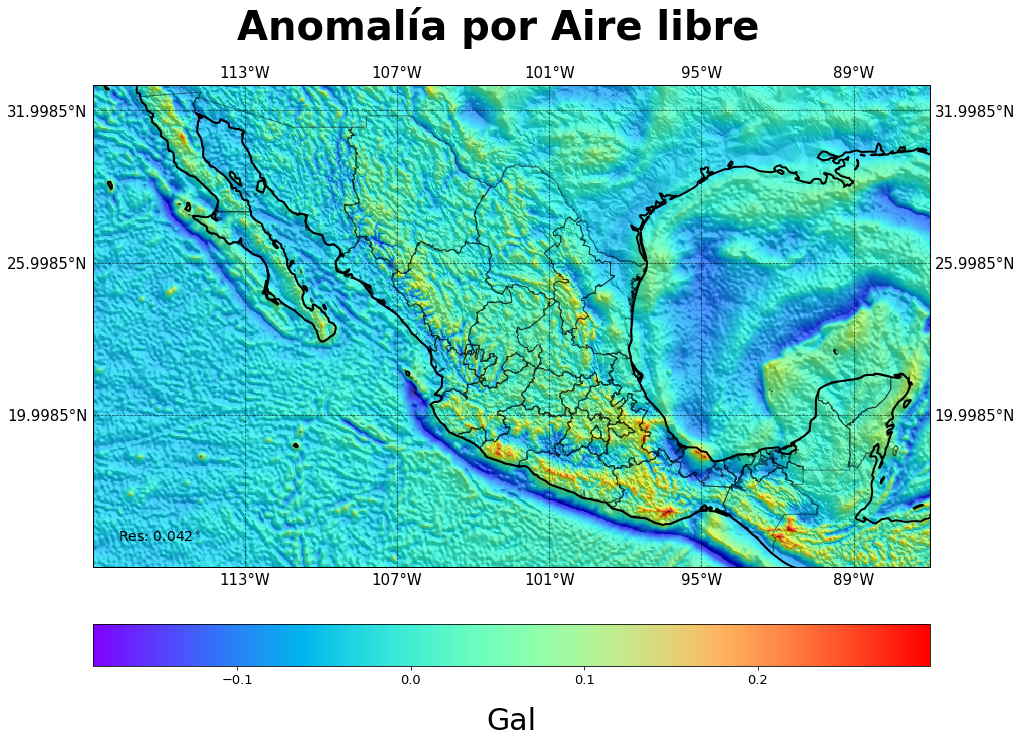

In [447]:
##Resultado de correr la función "fullnne", Titulo del Mapa, Nombre del archivo en el que se guardara, 
#Shp de los estados de méxico
grafComp(res,'Anomalía por Aire libre','BougComp.png',mex)

## Función que elabora un mapa unicamente considerando el territorio continental de México

In [425]:
rescl=clipRasEnt('AAL.tif',19,'AAL')

/Users/Raul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # This is added back by InteractiveShellApp.init_path()
/Users/Raul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


In [13]:
def grafCor(res,tit,name,v,nn,mex,mun):
    
    

    hill= es.hillshade(res[0])

    plt.figure(figsize=(17,17))

    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    ext=[res[1][0],res[1][0]+res[1][1]*res[0].shape[1],+res[1][3]+res[1][-1]*res[0].shape[0],res[1][3]]
    ext2=[res[1][0]-v,v+res[1][0]+res[1][1]*res[0].shape[1],-v+res[1][3]+res[1][-1]*res[0].shape[0],v+res[1][3]]
    ax.set_extent(ext2, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='50m',linewidth=2)
    ax.add_feature(cfeature.OCEAN,facecolor='#365383') 
    ax.add_feature(cfeature.LAND,facecolor='gray')
    gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=.7,color='k',alpha=.7,linestyle='--')

    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER

    gl.xlocator=mticker.FixedLocator(np.arange(ext2[0],ext2[1]+1,1))
    gl.ylocator=mticker.FixedLocator(np.arange(ext2[2],ext2[3]+1,1))

    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}



    norm=cm.colors.Normalize(vmin=np.nanmin(res[0])/1000,vmax=np.nanmax(res[0])/1000)
    cmap=cm.jet
    cbar=plt.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=ax,shrink=1,pad=.15)
    cbar.ax.tick_params(labelsize=13)
    plt.suptitle(tit,y=.95,fontsize=40,fontweight='bold')
    #plt.text(-87.5,32,'Res: '+str(round(res[1][1],3))+'$^\circ$',fontsize=12)
    cbar.set_label('Gal',fontsize=30,labelpad=20)

    mun[mun.CVE_ENT=='19'].boundary.plot(ax=ax,ec='k',linewidth=1)
    mex[mex.CVE_ENT!=str(nn)].plot(ax=ax,ec='k',linewidth=3,color='#C4B899')
    
    ax.imshow(hill, origin='upper', transform=ccrs.PlateCarree(),
              extent=ext, cmap='gray')

    ax.imshow(res[0], origin='upper', transform=ccrs.PlateCarree(),
              extent=ext, cmap='jet',alpha=.7)
    
    

    #plt.savefig(name,dpi=800,bbox_inches='tight');

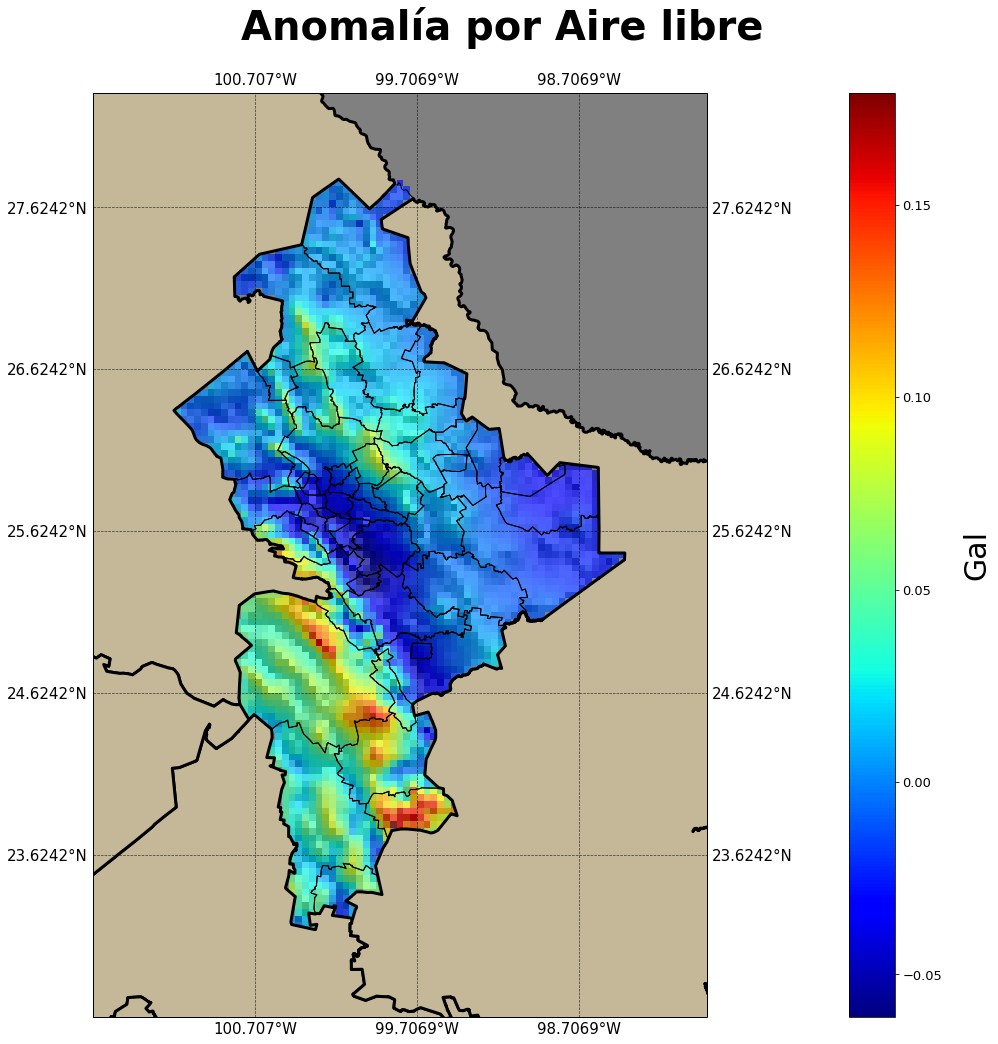

In [428]:
##Resultado de correr la función "fullnne", Titulo del Mapa, Nombre del archivo en el que se guardara,grados de separacion entre el marco 
#y el raster, clave de entidad, shp de estados, shp de muncipios
grafCor(rescl,'Anomalía por Aire libre','NLal.png',.5,19,mex,mun)

## Creación de un raster con la gravedad normal de una región a partir de una imagen georeferenciada de la región, esta imagen puede ser un dem del [CEM](https://www.inegi.org.mx/app/geo2/elevacionesmex/) o se pudo haber creado previamente a partir de un [polígono](https://desktop.arcgis.com/es/arcmap/10.3/tools/conversion-toolbox/polygon-to-raster.htm)

In [418]:
dem2=gdal.Open("AAL.tif") #Imagen creada a partir de un poligono

### Función que crea el raster con la gravedad normal de una región dada. Si el raster de entrada es muy grande se recomienda redimensionarlo multiplicandolo por $\frac{1}{rs}$, si se quiere trabajar con el tamaño original considere rs=1

In [14]:
def grav(rs,dem):
    data=np.array(dem.ReadAsArray()).astype('float')
    
    if rs!=1:
        data=cv.resize(data, dsize=(round(data.shape[1]/rs),round(data.shape[0]/rs)),interpolation=cv.INTER_CUBIC)
        
    ggt=list(dem.GetGeoTransform())
    ggt[1]=ggt[1]*rs
    ggt[-1]=ggt[-1]*rs
    for i in range(data.shape[0]):
        lt=ggt[-3]+i*ggt[-1]
        gv=gN(lt)
        data[i,:]=np.repeat(gv,len(data[i,:]))
        #data[i,:]=np.repeat(data[i,:]!=data[0,0],gv,data[i,:])
        
    #data=np.where(data==data[0,0],np.nan,data)
            
        
    return data,ggt

In [439]:
dta=grav(1,dem2)

/Users/Raul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


### Función de Graficación, es muy parecida a la funcion grafComp()

In [15]:
def mexGN(res,tit):   
    
    lon=[res[1][0]+i*res[1][1] for i in range(res[0].shape[1])]

    lat=[res[1][-3]+i*res[1][-1] for i in range(res[0].shape[0])]


    plt.figure(figsize=(15,15))

    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    ext=[min(lon),max(lon),min(lat),max(lat)]
    ax.set_extent(ext, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='50m',linewidth=2)
    ax.add_feature(cfeature.OCEAN,facecolor='#73A1C6') 
    ax.add_feature(cfeature.LAND,facecolor='#C4B899')
    gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=.7,color='k',alpha=.7,linestyle='--')

    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER

    gl.xlocator=mticker.FixedLocator(np.arange(ext[0],ext[1]+6,6))
    gl.ylocator=mticker.FixedLocator(np.arange(ext[2],ext[3]+6,6))

    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}

    norm=cm.colors.Normalize(vmin=np.nanmin(dta[0]),vmax=np.nanmax(dta[0]))
    cmap=cm.jet
    cbar=plt.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=ax,shrink=1,orientation='horizontal',pad=.07)
    cbar.ax.tick_params(labelsize=13)
    plt.suptitle(tit,y=.8,fontsize=40,fontweight='bold')
    plt.text(-118,15,'Res: '+str(round(res[1][1],3))+'$^\circ$',fontsize=15)
    cbar.set_label('Gal',fontsize=30,labelpad=20)

    ax.imshow(res[0], origin='upper', transform=ccrs.PlateCarree(),
              extent=[min(lon),max(lon),min(lat),max(lat)], cmap='jet')

#plt.savefig(name,dpi=800,bbox_inches='tight');

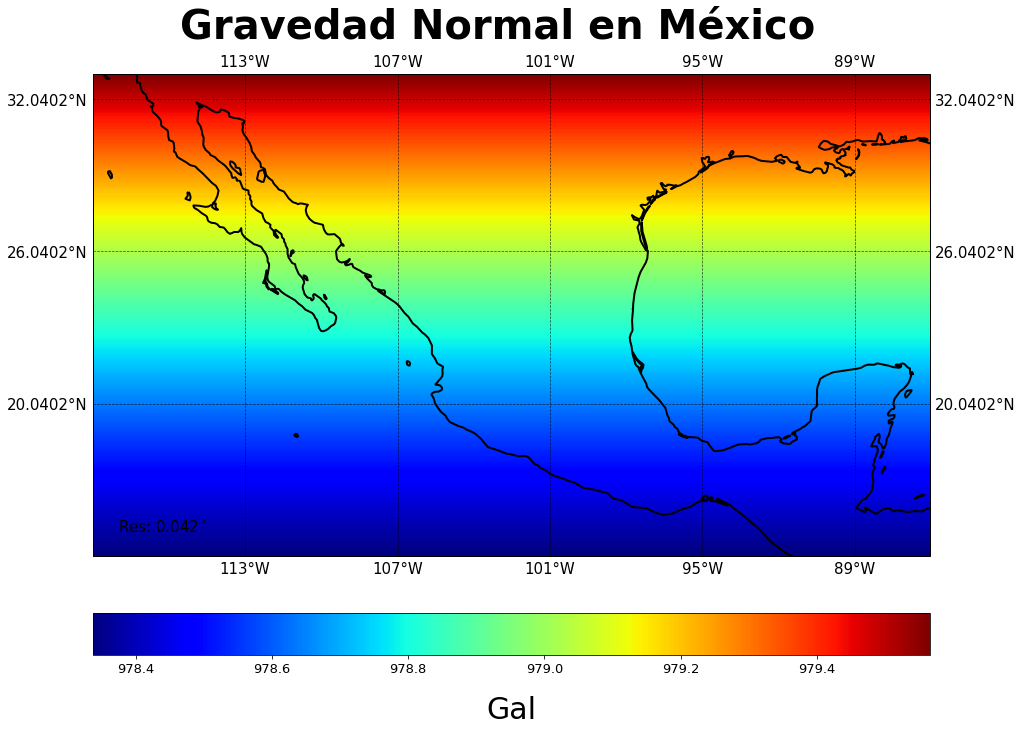

In [440]:
mexGN(dta,'Gravedad Normal en México')

In [430]:
aicor=dta[0]*1000+res[0]

In [433]:
saveImg(aicor,dta[1],'GAL')
rescl=clipRasEnt('GAL.tif',19,'GAL')

/Users/Raul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # This is added back by InteractiveShellApp.init_path()
/Users/Raul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


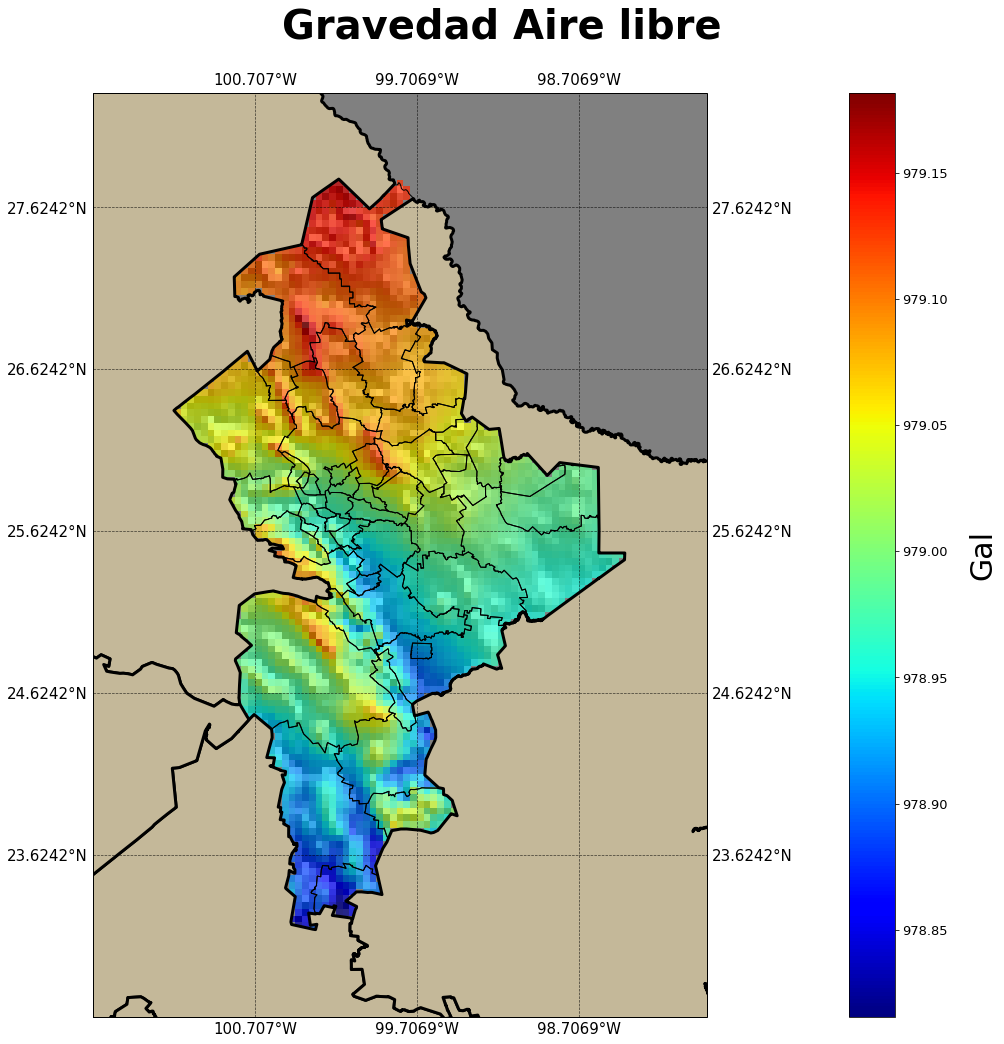

In [435]:
grafCor(rescl,'Gravedad Aire libre','NLal.png',.5,19,mex,mun)

In [4]:
fl=glob('/Users/Raul/Desktop/Data/*/*.txt')

In [7]:
c=0
for f in fl:
    n=''.join([i[0] for i in f.split('/')[-1][:-4].split(' ')])
    if c==0:
        dat=readtxt(f,n)
    else: 
        dat[n]=readtxt(f,n).iloc[:,-1]
    c+=1

In [8]:
dat['GN']=dat['lat'].swifter.apply(gN)

In [36]:
hb=((dat['AdBC']+dat['GN']-dat['CpT']-dat['GeM'])/0.1967 )  
hal=(dat['ApAL']+dat['GN']-dat['GeM'])/0.3086

In [38]:
h=[(i+j)/2 for i,j in zip(hb,hal)]

In [39]:
dat['H']=h

In [41]:
dat.to_csv('/Users/Raul/Desktop/Data/AllInOne.csv',index=False)

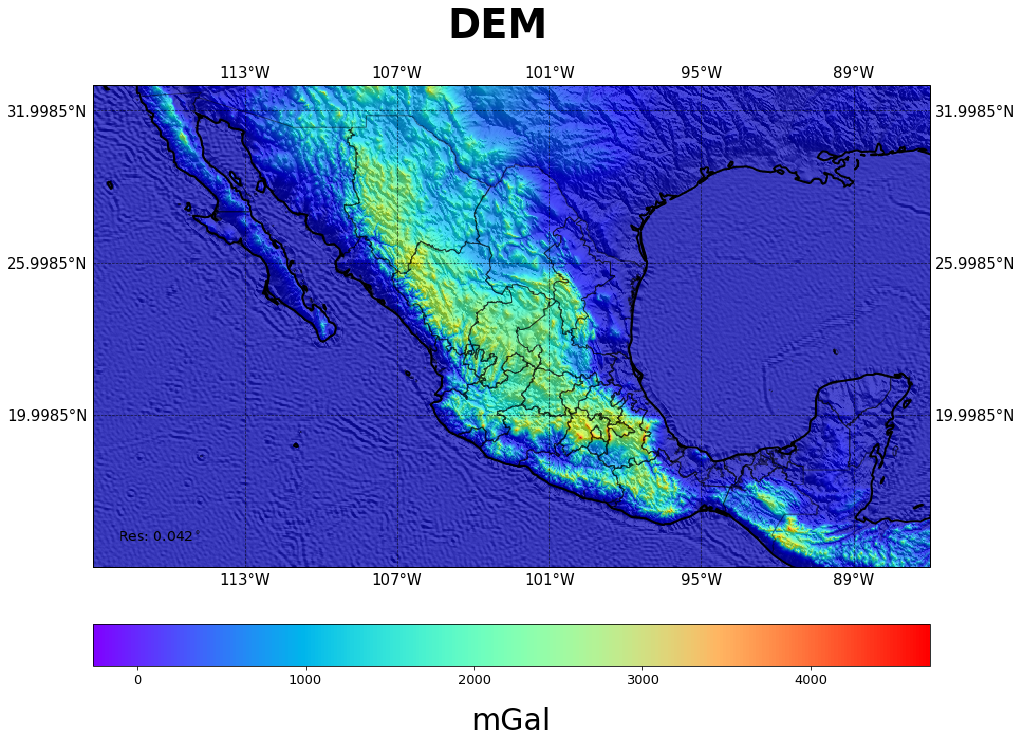

In [82]:
grafComp(imgcreator(dat,'H'),'DEM','DEM',mex)

In [16]:
dat=pd.read_csv('/Users/Raul/Desktop/Data/AllInOne.csv')

In [226]:
im=list(imgcreator(dat,'H'))

In [223]:
rs=5
im[0]=cv.resize(im[0], dsize=(round(im[0].shape[1]*rs),round(im[0].shape[0]*rs)),
               interpolation=cv.INTER_CUBIC)

im[1][1]=im[1][1]/rs
im[1][-1]=im[1][-1]/rs

In [227]:
im=list(imgcreator(dat,'H'))
tifcreator(im,'DTMex')

# Isostasia

In [466]:
#dat['dRho']=(2670*dat.H)/(dat.H+100*1000)
ro=[]
for i in dat.H:
    if i>=0:
        ro.append((2670*i)/(100*1000))
    else:
        ro.append(((2670-1027)*-i)/(100*1000+i))
        
dat['dRho']=ro

In [467]:
c=(100*1000)+dat.H
b=100*1000
a=((geodesic([dat['lat'].iloc[0],dat['lon'].iloc[0]],[dat['lat'].iloc[1],dat['lon'].iloc[1]]).km*1000)/2)+215

In [468]:
dat['Ac']=2*np.pi*constants.G*dat.dRho*(b+np.sqrt(a**2+(c-b)**2)-np.sqrt(a**2+c**2))*10e5

In [469]:
im=list(imgcreator(dat,'Ac'))
k=np.ones((3,3))
sAc=cv.filter2D(im[0],-1,k)
dat['Ac']=sAc.reshape(1,len(dat))[0]

In [470]:
np.sum(sAc+bc[0])/len(dat)

-0.003742319227892331

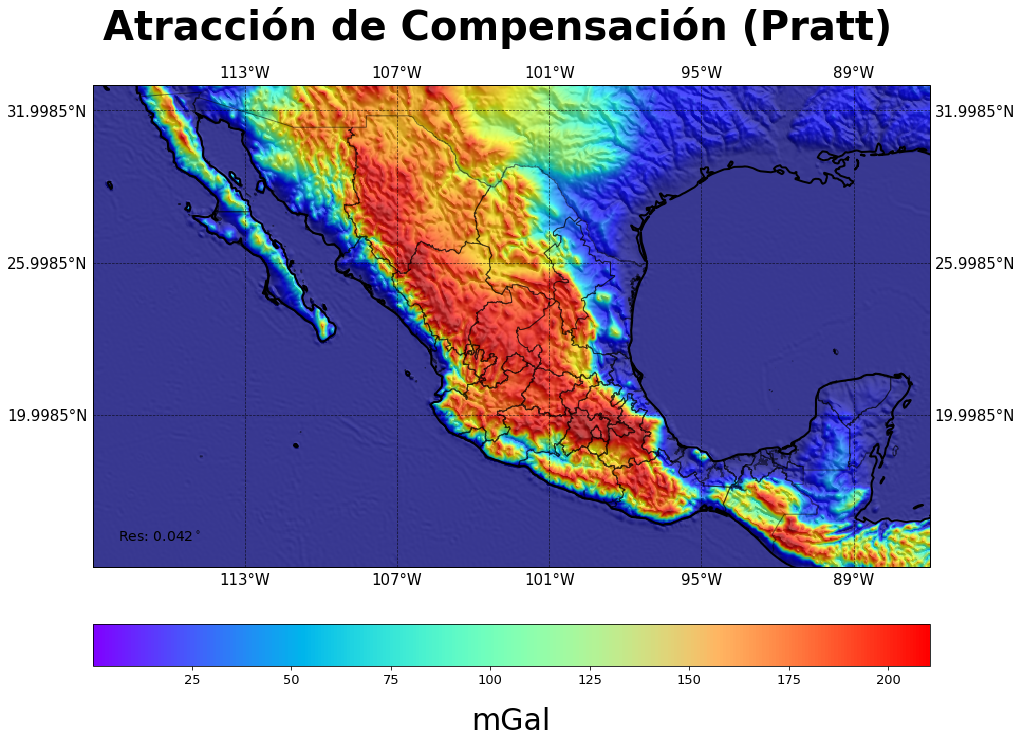

In [464]:
grafComp((sAc,im[1]),'Atracción de Compensación (Pratt)','Ac',mex,False)

In [ ]:
tifcreator([sAc,im[1]],'Ac')

In [473]:
dat.to_csv('AllInOne.csv',index=False)

In [480]:
dat['AnIs']=dat.Ac+dat.AdBC

In [523]:
x = pl[~np.isnan(pl)]

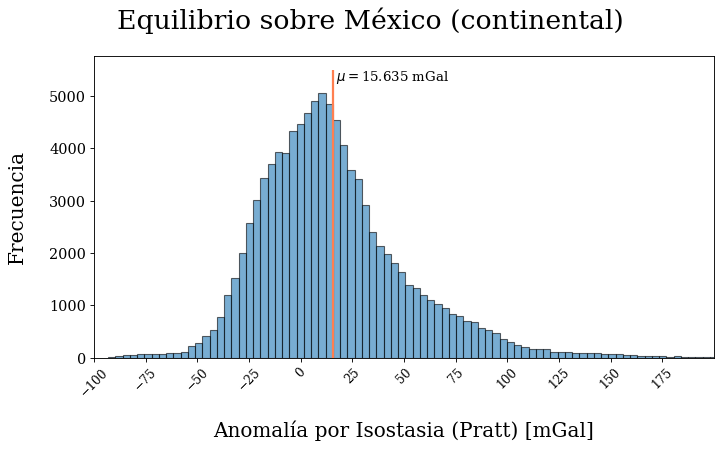

In [548]:
plt.figure(figsize=(10,5),dpi=80)
plt.hist(x,bins=100,ec='k',alpha=.6)
plt.vlines(np.mean(x),0,5500,color='coral',linewidth=2)
plt.text(17,5300,'$\mu = $'+str(round(np.mean(x),3))+' mGal',fontsize=12,fontname='serif')
plt.xticks(np.arange(-175,180,25),rotation=45,fontname='serif',size=11)
plt.xlim(-100,200)
plt.yticks(size=13,fontname='serif')
plt.xlabel('Anomalía por Isostasia (Pratt) [mGal]',size=18,fontname='serif',labelpad=20)
plt.ylabel('Frecuencia',size=18,fontname='serif',labelpad=20)
plt.suptitle('Equilibrio sobre México (continental)',size=24,fontname='serif',y=1,x=.47)
plt.savefig('histPratt.png',bbox_inches='tight',dpi=400);

Text(0, 0.5, 'Frecuencia')

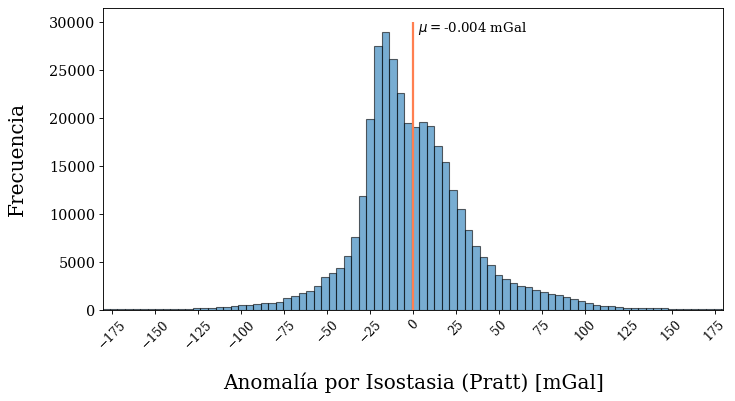

In [481]:
plt.figure(figsize=(10,5),dpi=80)
plt.hist(dat.AnIs,bins=100,ec='k',alpha=.6)
plt.vlines(np.mean(dat.AnIs),0,30000,color='coral',linewidth=2)
plt.text(3,29000,'$\mu = $'+str(round(np.mean(dat.AnIs),3))+' mGal',fontsize=12,fontname='serif')
plt.xticks(np.arange(-175,180,25),rotation=45,fontname='serif',size=11)
plt.xlim(-180,180)
plt.yticks(size=13,fontname='serif')
plt.xlabel('Anomalía por Isostasia (Pratt) [mGal]',size=18,fontname='serif',labelpad=20)
plt.ylabel('Frecuencia',size=18,fontname='serif',labelpad=20)
#dat.AnIs.plot.kde();

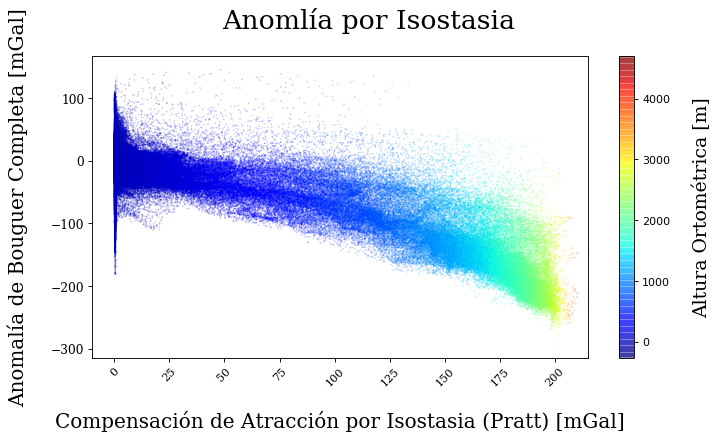

In [546]:
plt.figure(figsize=(10,5),dpi=80)
plt.scatter(dat.Ac,dat.AdBC,c=dat.H,s=.05,alpha=.5,cmap='jet')
cbar=plt.colorbar()
cbar.ax.set_ylabel('Altura Ortométrica [m]',size=17,fontname='serif',labelpad=20)
plt.xlim(-10,215)
plt.xticks(rotation=45,fontname='serif')
plt.yticks(size=11,fontname='serif')
plt.xlabel('Compensación de Atracción por Isostasia (Pratt) [mGal]',size=18,fontname='serif',labelpad=20)
plt.ylabel('Anomalía de Bouguer Completa [mGal]',size=18,fontname='serif',labelpad=20)
plt.suptitle('Anomlía por Isostasia',size=24,fontname='serif',y=1,x=.47)
plt.savefig('isobc.png',bbox_inches='tight',dpi=400)

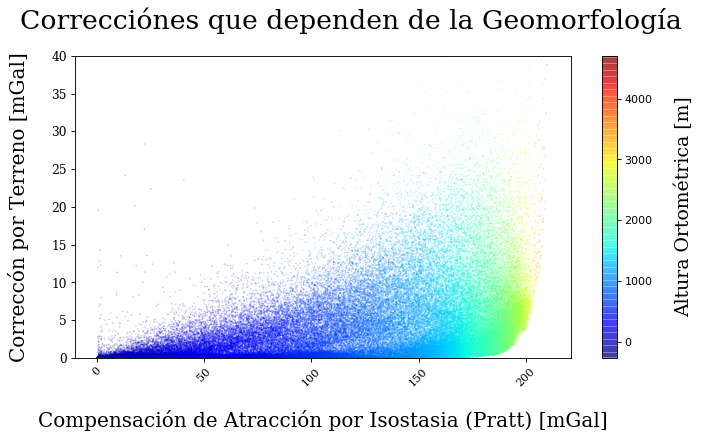

In [547]:
plt.figure(figsize=(10,5),dpi=80)
plt.scatter(dat.Ac,dat.CpT,s=.05,alpha=.5,c=dat.H,cmap='jet')
cbar=plt.colorbar()
cbar.ax.set_ylabel('Altura Ortométrica [m]',size=17,fontname='serif',labelpad=20)
#plt.xlim(-1,20)
plt.xticks(rotation=45,fontname='serif')
plt.yticks(size=11,fontname='serif')
plt.xlabel('Compensación de Atracción por Isostasia (Pratt) [mGal]',size=18,fontname='serif',labelpad=20)
plt.ylabel('Correccón por Terreno [mGal]',size=18,fontname='serif',labelpad=20)
plt.suptitle('Correcciónes que dependen de la Geomorfología',size=24,fontname='serif',y=1,x=.47)
plt.ylim(0,40)
plt.savefig('isoct.png',bbox_inches='tight',dpi=400)

In [491]:
tifcreator(imgcreator(dat,'AnIs'),'AnomIso')

In [495]:
mex=gpd.read_file('/Users/Raul/Desktop/Data/contdv250kgw/contdv250kgw.shp')
mex=mex.to_crs({'init': 'epsg:6365'})
#nv=mex[mex.CVE_ENT==str(nn)]
#nv=nv.to_crs({'init': 'epsg:6365'})
coords=getFeatures(mex)

data = rasterio.open('/Users/Raul/Desktop/Data/tif/AnomIso.tif')

out_img, out_transform = mask(data, shapes=coords, crop=True)
pl=out_img.astype('Float32')[0]
pl=np.where(pl==9999999,np.nan,pl)
ggt2=list(out_transform)
ggt2=[ggt2[2],ggt2[0],0,ggt2[-4],0,ggt2[-5]]

/Users/Raul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # Remove the CWD from sys.path while we load stuff.


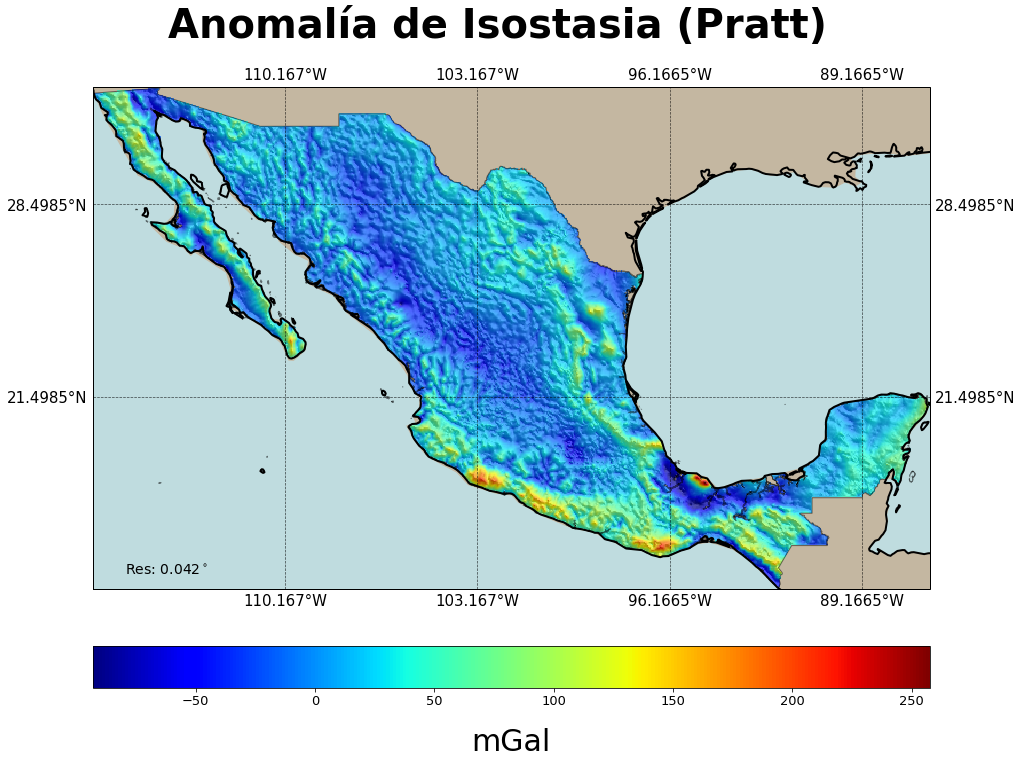

In [549]:
grafComp([pl,ggt2],'Anomalía de Isostasia (Pratt)','AnIso',mex,False)

## Mapa Web

In [1]:
gdf = gpd.GeoDataFrame(gnl, geometry=gpd.points_from_xy(gnl.lon, gnl.lat))

NameError: name 'gpd' is not defined

In [ ]:
mapa = folium.Map(location=[24, -101.4], 
                  zoom_start=5.49,tiles='Stamen Terrain',control_scale=True,height='82%')
mc = MarkerCluster()

minimap=plugins.MiniMap(toggle_display=True)
mapa.add_child(minimap)
plugins.Fullscreen(position='bottomleft').add_to(mapa)
plugins.MousePosition(position='topright',prefix='Lat:',separator='  Lon: ').add_to(mapa)

measure_control = plugins.MeasureControl(position='topleft', 
                                 active_color='red', 
                                 completed_color='red', 
                                 primary_length_unit='meters')
mapa.add_child(measure_control)

draw = plugins.Draw()
draw.add_to(mapa)

fg1=folium.FeatureGroup(name='Estaciones', show=True)
fg2=folium.FeatureGroup(name='Estados Asignados', show=False)

mapa.add_child(fg1)
mapa.add_child(fg2)

for row in gnl.itertuples():
    
    popup_df = pd.DataFrame(columns=['Medición','Valor'],data=[['Gravedad', str(row.Grav)+'mGal'],['Gravedad Normal',str(round(row.GravN,4))+'mGal'], 
                                                               ['Bouger Simple',str(row.Bs)+'mGal'],['Bouger Completa',str(row.Bc)+'mGal'], 
                                                               ['Corrección Topográfica',str(row.Ct)+'mGal'],['Anomlía de Aire libre',str(round(row.gAl,4))+'mGal'],
                                                               ['Altura Ortométrica',str(row.hNAVD29)+'m']])
    popup_html = popup_df.to_html(classes='table table-hover table-responsive-sm text-center', index=False, 
                                  header=True,justify='center')
    
    if ((row.CVE[:2]=='19') | (row.CVE[:2]=='13')| (row.CVE[:2]=='16')| (row.CVE[:2]=='05')):
        cc='red'
    else:
        cc='gray'
  
    mc.add_child(folium.Marker(location=[row.lat,  row.lon],
                 popup='<h4>Estación: '+row.ID+'</h4>'+'<p>'+row.NOM_ENT+', '+row.NOM_MUN+'</p>'+'<p>Latitud: '+str(row.lat)+'°</p>'+'<p>Longitud: '+str(row.lon)+'°</p>'+popup_html,
                               tooltip='EGG+BNV: '+row.ID,icon=folium.Icon(color=cc, icon='angle-double-down',prefix='fa')))


fg1.add_child(mc)

tit1="<h1 class='text-center'>Bancos de nivel verticales con datos gravimétricos (RGNP)</h1>"
est="<h3 class='text-muted text-right'>"+str(len(gnl))+" estaciones</small></h3>"

mapa.get_root().html.add_child(folium.Element(tit1))

mapa.get_root().html.add_child(folium.Element(est))


for i in ['19','13','16','05']:
    
    if i=='19':
        style = '#B84747'
    elif i=='13':
        style = '#2EE1BD'
    elif i=='16':
        style = '#C4D235'
    elif i=='05':
        style = '#944CBD'
   
    munis=mun[(mun.CVEGEO.str[:2]==i)]
    munis['color']=style
    cnt=gnl[gnl.CVE.str[:2]==i]['CVE'].value_counts().reset_index().rename(columns={'index':'CVEGEO','CVE':'cnt'})
    sb=munis[~munis.CVEGEO.isin(cnt.CVEGEO)]['CVEGEO']
    cnt=cnt.append(pd.DataFrame({'CVEGEO':sb,'cnt':np.repeat(0,len(sb))}))
    munis=pd.merge(munis,cnt,on='CVEGEO')
    munis=munis.to_json()
    folium.GeoJson(munis,
                  tooltip=folium.GeoJsonTooltip(fields=['NOM_ENT','NOM_MUN','cnt'],
                                             aliases=['Estado:','Muncipio:','# Estaciones:']),
                  style_function=lambda x: {'color' : x['properties']['color'],
                                            'opacity': 0.3,
                                            'fillColor' : x['properties']['color'],
                                            }).add_to(fg2)

folium.LayerControl().add_to(mapa)


mapa.save("index.html")

webbrowser.open('index.html')
#mapa